# GPU Acceleration

This notebook is intended to demonstrate GPU-acceleration of `superscreen` models.

Below we will look at the time required to solve both single-layer and multi-layer models using three different methods:

1. `Numpy (CPU)`: This is the default behavior when you call `superscreen.solve()` or `superscreen.solve(..., gpu=False)`.
2. `JAX (CPU)`: This method will be used if you call `superscreen.solve(..., gpu=True)` on a machine that has JAX installed but does not have a GPU available. We test this method by forcing JAX to run on the CPU even if a GPU is available using the context manager `jax.default_device(jax.devices("cpu")[0])`.
3. `JAX (GPU)`: This method will be used if you call `superscreen.solve(..., gpu=True)` on a machine that has JAX installed and has a GPU available. This notebook will simply skip this method if no GPU is available.

There are several things to keep in mind in order to get the most out of `SuperScreen` on a GPU:

- Currently, only computation performed inside `superscreen.solve()` can be offloaded to a GPU. Post-processing methods belonging to `superscreen.Solution` cannot (currently) be run on a GPU. Calculations that make heavy use of these post-processing methods (such as fluxoid optimization) can be expected to show only modest speed-ups from GPU acceleration.
- There is some overhead associated with moving data onto the GPU for processing, so calls to `superscreen.solve()` that take only 10s of ms on the CPU (e.g. single-layer models with only 1,000 or so mesh vertices) may actually be slightly slower on the GPU.
- On the other hand, most data only needs to be transferred to the GPU once per call to `superscreen.solve()`, so large gains can be seen when iteratively solving models involving multi-layer devices.

In short, **you can expect the biggest speed-ups for models with many mesh vertices and/or more than one layer**.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

from collections import defaultdict

import jax
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 12

import superscreen as sc
from superscreen.geometry import circle

## Setup

In [2]:
sc.version_table()

Software,Version
SuperScreen,0.6.1
Numpy,1.23.1
SciPy,1.8.1
matplotlib,3.5.2
ray,1.13.0
jax,0.3.15
IPython,8.4.0
Python,"3.9.12 (main, Jun 1 2022, 11:38:51) [GCC 7.5.0]"
OS,posix [linux]
Number of CPUs,"Physical: 2, Logical: 2"


In [3]:
def run_benchmark(device, min_points_values, solve_kwargs):
    mesh_sizes = []
    results = defaultdict(list)
    for min_points in min_points_values:
        device.make_mesh(min_points=min_points, optimesh_steps=10)
        mesh_sizes.append(device.points.shape[0])
        print(f"Mesh size: {device.points.shape[0]}")

        key = "Numpy (CPU)"
        print(f"    {key}: ", end="")
        timing = %timeit -o sc.solve(device, **solve_kwargs)
        results[key].append(timing)

        key = "JAX (CPU)"
        print(f"    {key}: ", end="")
        with jax.default_device(jax.devices("cpu")[0]):
            timing = %timeit -o sc.solve(device, gpu=True, **solve_kwargs)
        results[key].append(timing)

        key = "JAX (GPU)"
        print(f"    {key}: ", end="")
        if "cpu" in jax.devices()[0].device_kind:
            print("Skipping because there is no GPU available.")
        else:
            timing = %timeit -o sc.solve(device, gpu=True, **solve_kwargs)
            results[key].append(timing)

    return np.array(mesh_sizes), dict(results)

In [4]:
def plot_benchmark(mesh_sizes, results):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, constrained_layout=True)
    ys_ref = np.array([t.average for t in results["Numpy (CPU)"]])
    for label, timing in results.items():
        xs = mesh_sizes
        ys = np.array([t.average for t in timing])
        yerr = np.array([t.stdev for t in timing])
        for ax in axes[:2]:
            ax.errorbar(xs, ys, yerr=yerr, marker="o", ls="--", label=label)
        axes[2].plot(xs, ys_ref / ys, marker="o", ls="--")
    for ax in axes:
        ax.set_xlabel("Mesh size")
        ax.set_ylabel("Solve time [s]")
        ax.grid(True)
    axes[2].set_ylabel("Speed-up vs. Numpy (CPU)")
    axes[0].legend(loc=0)
    axes[1].set_yscale("log")
    return fig, axes

## Single layer device

Here we model a single-layer superconducting ring with some circulating current.

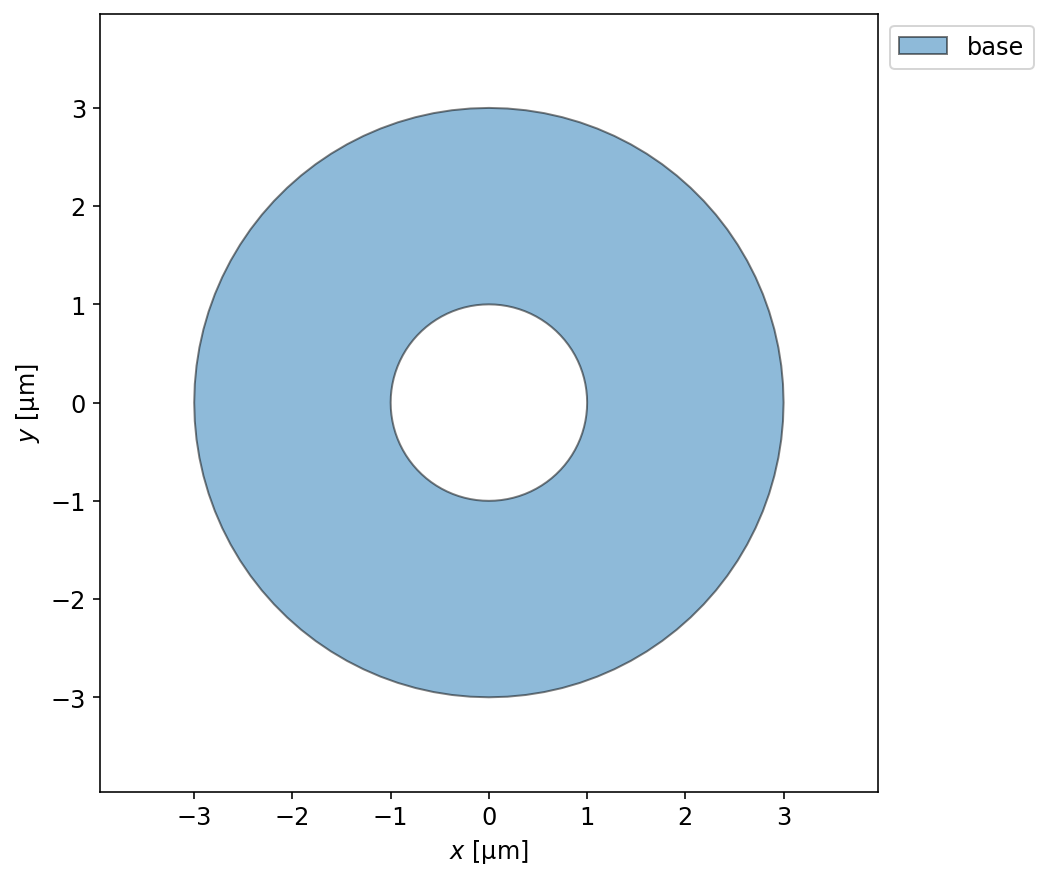

In [5]:
length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)

ring = circle(ro)
hole = circle(ri)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    "ring",
    layers=[sc.Layer("base", london_lambda=0.100, thickness=0.025, z0=0)],
    films=[sc.Polygon("ring", layer="base", points=ring)],
    holes=[sc.Polygon("hole", layer="base", points=hole)],
    abstract_regions=[bounding_box],
    length_units=length_units,
)
device.solve_dtype = "float32"

fig, ax = device.draw(exclude="bounding_box", legend=True)

In [6]:
# Model the device with 1 mA circulating current
circulating_currents = {"hole": "1 mA"}
solve_kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
    log_level=None,
)

# Look at solve time vs. mesh size
min_points = 1000 * np.arange(1, 11, dtype=int)

In [7]:
mesh_sizes, results = run_benchmark(device, min_points, solve_kwargs)

Mesh size: 1008
    Numpy (CPU): 23.5 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    JAX (CPU): 37.4 ms ± 942 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 38.9 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 2056
    Numpy (CPU): 117 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    JAX (CPU): 156 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 87.8 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 3091
    Numpy (CPU): 237 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 381 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 181 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 4150
    Numpy (CPU): 450 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 695 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU)

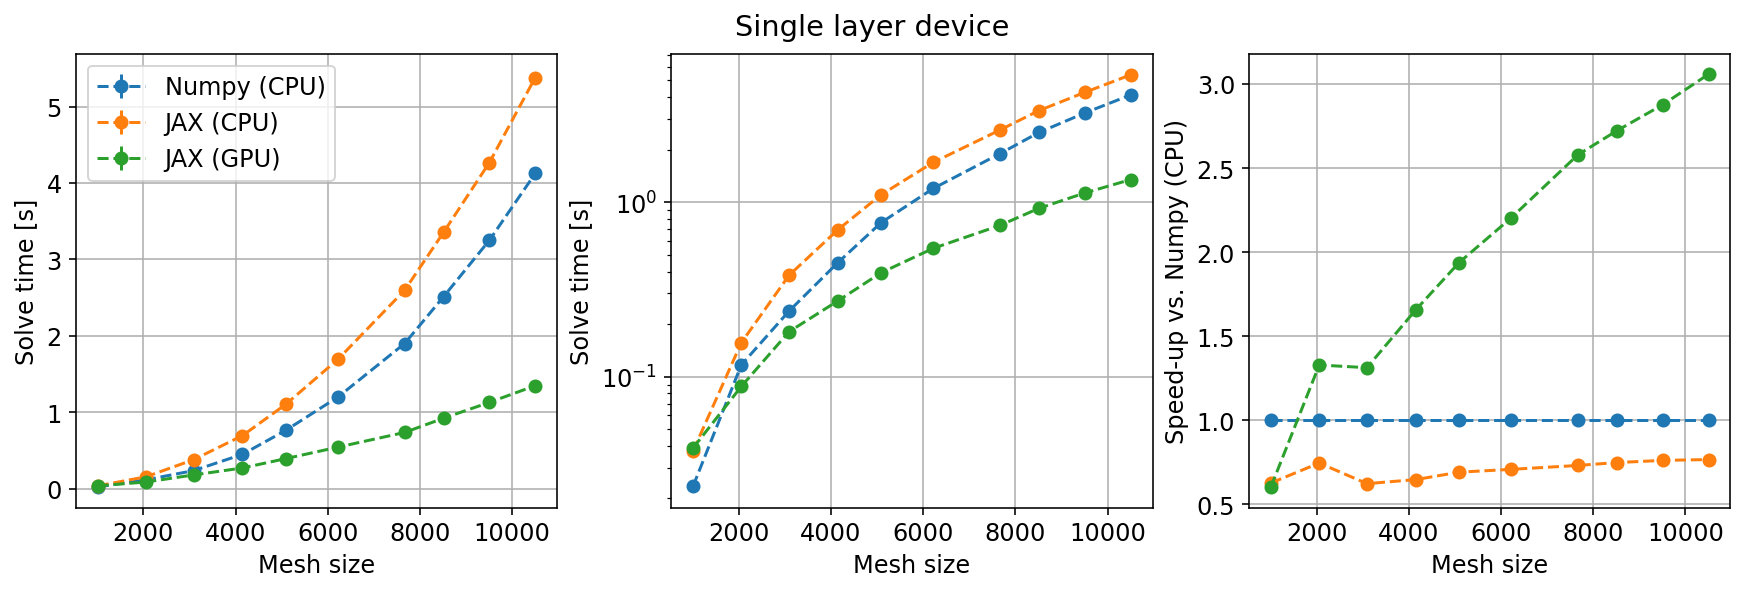

In [8]:
fig, axes = plot_benchmark(mesh_sizes, results)
_ = fig.suptitle("Single layer device")

## Multi-layer device

Here we model a scanning Superconducting QUantum Interference Device (SQUID) susceptometer, which consists of three superconducting layers.

In [9]:
import squids

In [10]:
device = squids.ibm.large.make_squid()
device.solve_dtype = "float32"

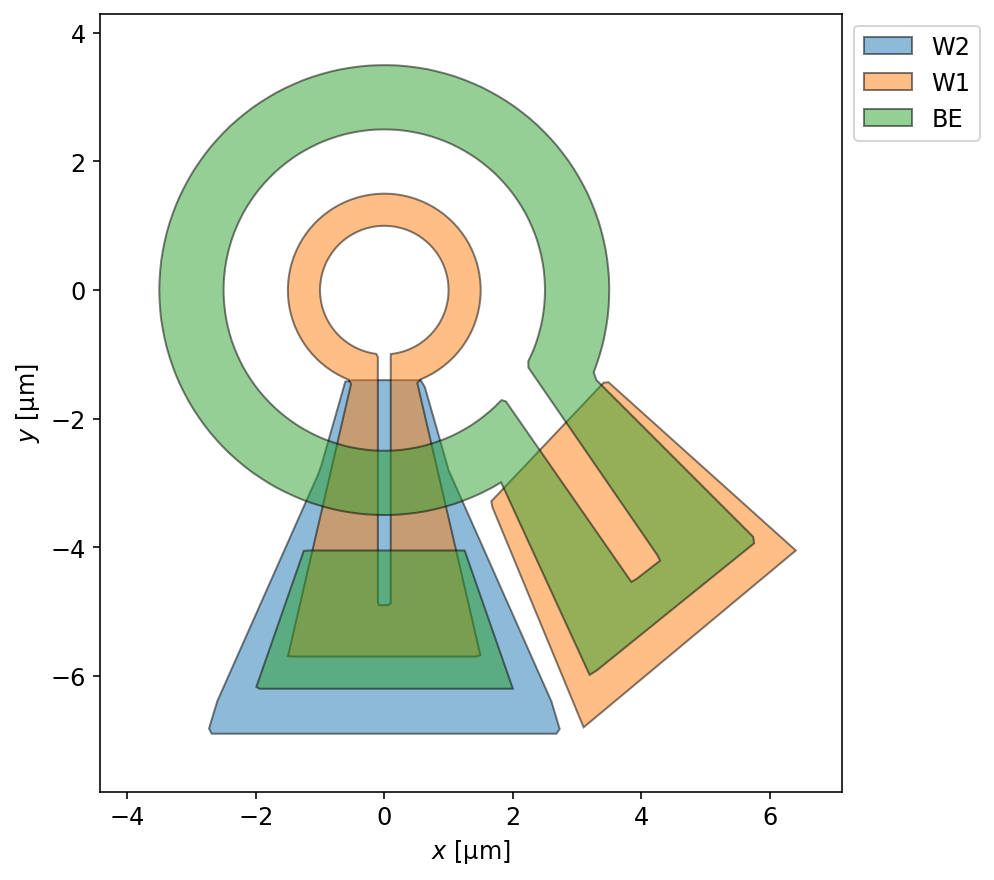

In [11]:
_ = device.draw(exclude="bounding_box", legend=True)

In [12]:
# Model the device with 1 mA circulating current
I_circ = device.ureg("1 mA")
circulating_currents = {"fc_center": str(I_circ)}
solve_kwargs = dict(
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
    log_level=None,
    iterations=5,
)

import logging
logging.getLogger("superscreen.solve").setLevel(logging.CRITICAL)

# Look at solve time vs. mesh size
min_points = 1000 * np.arange(2, 11, dtype=int)

In [13]:
mesh_sizes, results = run_benchmark(device, min_points, solve_kwargs)

Mesh size: 2234
    Numpy (CPU): 1.59 s ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 1.54 s ± 7.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 823 ms ± 8.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 3015
    Numpy (CPU): 2.87 s ± 5.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 2.86 s ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1 s ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 4022
    Numpy (CPU): 4.95 s ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 4.48 s ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.23 s ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mesh size: 5467
    Numpy (CPU): 9.04 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (CPU): 8.02 s ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    JAX (GPU): 1.6

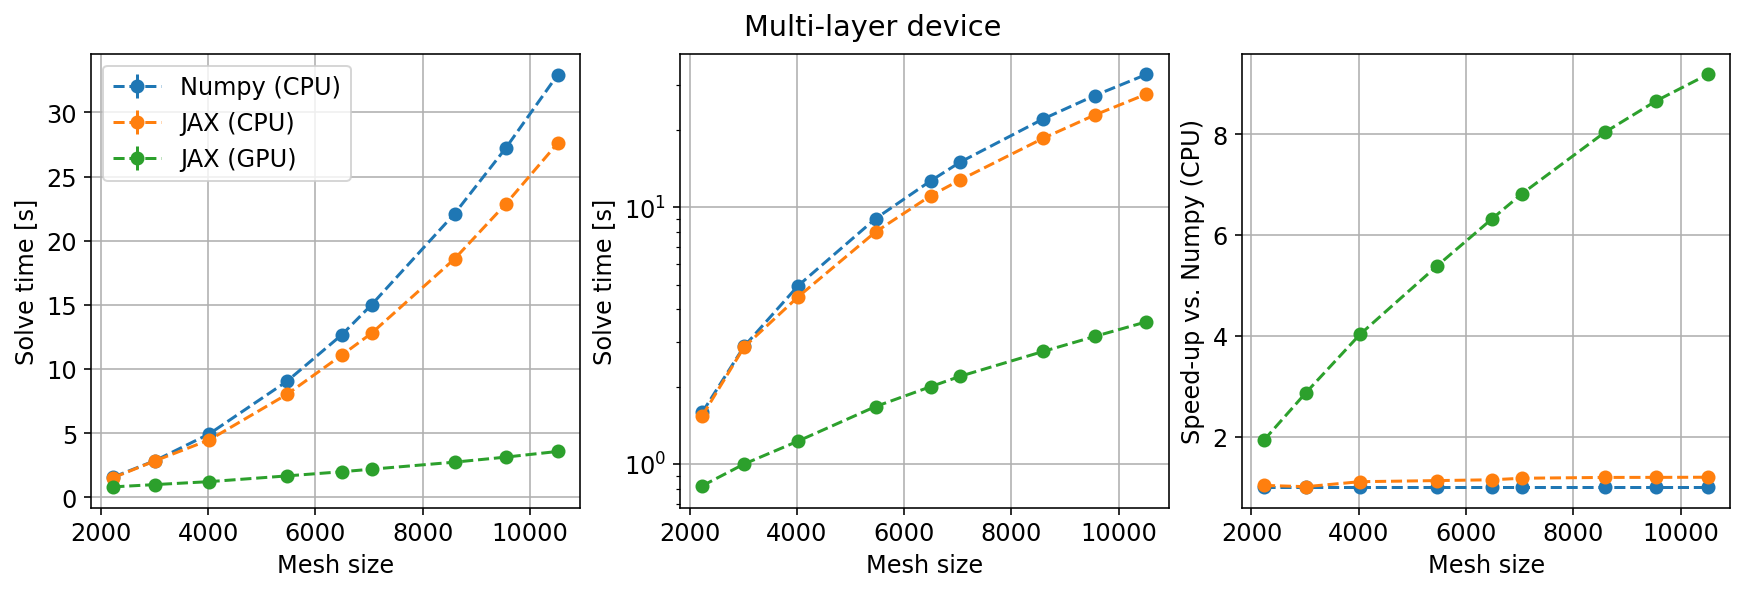

In [14]:
fig, axes = plot_benchmark(mesh_sizes, results)
_ = fig.suptitle("Multi-layer device")